In [19]:
!pip install -r requirements.txt

  Using cached coloredlogs-15.0.1-py2.py3-none-any.whl.metadata (12 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached humanfriendly-10.0-py2.py3-none-any.whl.metadata (9.2 kB)
  Using cached levenshtein-0.27.1-cp312-cp312-win_amd64.whl.metadata (3.6 kB)
  Using cached onnxruntime-1.22.0-cp312-cp312-win_amd64.whl.metadata (5.0 kB)
  Using cached pillow-11.2.1-cp312-cp312-win_amd64.whl.metadata (9.1 kB)
  Using cached protobuf-6.31.1-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached pyreadline3-3.5.4-py3-none-any.whl.metadata (4.7 kB)
  Using cached rapidfuzz-3.13.0-cp312-cp312-win_amd64.whl.metadata (12 kB)
Using cached coloredlogs-15.0.1-py2.py3-none-any.whl (46 kB)
Using cached flatbuffers-25.2.10-py2.py3-none-any.whl (30 kB)
Using cached humanfriendly-10.0-py2.py3-none-any.whl (86 kB)
Using cached levenshtein-0.27.1-cp312-cp312-win_amd64.whl (100 kB)
Using cached onnxruntime-1.22.0-cp312-cp312-win_amd64.whl (12.7 MB)
Using cach

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.40.1 requires protobuf<6,>=3.20, but you have protobuf 6.31.1 which is incompatible.


In [20]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
from easyocr import easyocr
import re
from Levenshtein import distance as levenshtein_distance

In [4]:
cascade = cv2.CascadeClassifier('Haar/haarcascade_license_plate_rus_16stages.xml')

def preprocess(image):
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    # 1. Удаление "перцового" шума
    denoised = cv2.medianBlur(gray, 3)  # Можно 5, если сильно шумно
    # 2. (опц.) Билатеральная фильтрация — сохраняет края
    denoised = cv2.bilateralFilter(denoised, d=3, sigmaColor=50, sigmaSpace=50)
    # 3. (опц.) Увеличить контраст
    denoised = cv2.equalizeHist(denoised)
    plates = cascade.detectMultiScale(denoised, scaleFactor=1.1)

    plate_candidate = None
    for (x, y, w, h) in plates:
        aspect_ratio = w / float(h)
        if 3.7 < aspect_ratio < 5.0 and 140 < w < 250:
            plate_candidate = (x, y, w, h)
            cv2.rectangle(denoised, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return denoised, plate_candidate

In [7]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from easyocr import easyocr
import re


# убираем шум
def prepare_plate_img(plate_img):
    img_gray = cv2.cvtColor(plate_img.copy(), cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(img_gray, (3, 3), 1)
    threshold, binary_img = cv2.threshold(blurred, 80, 255, cv2.THRESH_BINARY)

    # Создаем ядро (структурный элемент) для морфологических операций — квадрат 2x2 пикселей
    kernel = np.ones((2, 2), np.uint8)
    # 2) Дилатация — расширяет белые области, увеличивает объекты, заполняет пробелы
    dilation = cv2.dilate(binary_img, kernel, iterations=1, borderType=cv2.BORDER_CONSTANT)
    return dilation

def clean_text(text):
    # Keep only letters and digits
    cleaned = re.sub(r'[^A-Za-zА-Яа-яЁё0-9]', '', text)

    # Safety check
    if len(cleaned) <= 5:
        return cleaned  # Too short to split

    # Split after index 5
    return cleaned[:6] + ' ' + cleaned[6:]

def get_text(plate_img):
    reader = easyocr.Reader(['ru'])
    results = reader.readtext(plate_img)
    text_string = ' '.join([res[1] for res in results])
    text_string = clean_text(text_string)
    return text_string.lower()


def calculate_cer(true_text, text):
    cer = levenshtein_distance(text.strip(), true_text) / len(true_text)
    return cer

In [9]:
import abc
import random
class ImageTransformer(abc.ABC):
    @abc.abstractmethod
    def random_transform(self, img: np.ndarray) -> np.ndarray:
        pass


class ColorTransformer(ImageTransformer):
    def random_transform(self, img: np.ndarray) -> np.ndarray:
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)

        # Random hue (-10 to +10), saturation (0.8–1.2), brightness (0.8–1.2)
        hue_shift = random.uniform(-1, 1)
        sat_mult = random.uniform(0.9, 1.1)
        val_mult = random.uniform(0.9, 1.1)

        hsv[..., 0] = (hsv[..., 0] + hue_shift) % 180
        hsv[..., 1] *= sat_mult
        hsv[..., 2] *= val_mult

        # Clip and convert back
        hsv = np.clip(hsv, 0, 255).astype(np.uint8)
        return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

class GeometricTransformer(ImageTransformer):
    def random_transform(self, img: np.ndarray) -> np.ndarray:
        h, w = img.shape[:2]

        transform_type = random.choice([
           "crop", "zoom", "shift"
        ])

        if transform_type == "crop":
            start_x = random.randint(0, w // 10)
            start_y = random.randint(0, h // 10)
            end_x = w - random.randint(0, w // 10)
            end_y = h - random.randint(0, h // 10)
            cropped = img[start_y:end_y, start_x:end_x]
            return cv2.resize(cropped, (w, h))

        elif transform_type == "zoom":
            scale = random.uniform(0.8, 1.2)
            resized = cv2.resize(img, None, fx=scale, fy=scale)
            if scale < 1:
                pad_w = (w - resized.shape[1]) // 2
                pad_h = (h - resized.shape[0]) // 2
                return cv2.copyMakeBorder(resized, pad_h, pad_h, pad_w, pad_w,
                                          borderType=cv2.BORDER_REFLECT)
            else:
                return resized[:h, :w]

        elif transform_type == "shift":
            dx = random.randint(-w // 2, w // 2)
            dy = random.randint(-h // 2, h // 2)
            matrix = np.float32([[1, 0, dx], [0, 1, dy]])
            return cv2.warpAffine(img, matrix, (w, h), borderMode=cv2.BORDER_REFLECT)


        return img

class NoiseTransformer(ImageTransformer):
    def random_transform(self, img: np.ndarray) -> np.ndarray:
        noise_type = random.choice(["poisson", "salt", "pepper"])
        output = img.copy()

        if noise_type == "poisson":
            noisy = np.random.poisson(img.astype(np.float32))
            output = np.clip(noisy, 0, 255).astype(np.uint8)

        elif noise_type == "salt":
            amount = 0.01
            num_salt = int(amount * img.size)
            coords = [np.random.randint(0, i - 1, num_salt) for i in img.shape[:2]]
            output[coords[0], coords[1]] = 255

        elif noise_type == "pepper":
            amount = 0.01
            num_pepper = int(amount * img.size)
            coords = [np.random.randint(0, i - 1, num_pepper) for i in img.shape[:2]]
            output[coords[0], coords[1]] = 0

        return output


colorTransformer = ColorTransformer()
geometricTransformer = GeometricTransformer()
noiseTransformer = NoiseTransformer()
default_transformations = [colorTransformer, noiseTransformer, geometricTransformer]

def apply_augmentation(img: np.ndarray, transformations=default_transformations) -> np.ndarray:
    transformed_img = img.copy()
    for transform in transformations:
        transformed_img = transform.random_transform(transformed_img)
    return transformed_img

In [11]:
def apply_pipeline(path, plate_text):
    img = cv2.imread(path)
    img = apply_augmentation(img)
    output_img, plate_coord = preprocess(img.copy())
    plate_img = None
    if plate_coord is not None:
        x, y, w, h = plate_coord
        plate_img = output_img[y:y + h, x:x + w]
        plate_text_recognized = get_text(plate_img)
        print(f"original\t{plate_text}")
        print(f"detected\t{plate_text_recognized}")
        cer = calculate_cer(plate_text, plate_text_recognized)
        print(f"CER: {cer}")


    f, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(output_img)
    if plate_img is not None:
        axes[1].imshow(plate_img)
    plt.show()

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


original	н764ке 799
detected	н764ке 99
CER: 0.1


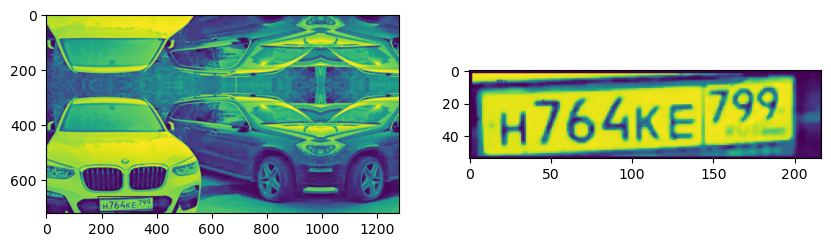

In [23]:
apply_pipeline('car1.jpg', 'н764ке 799')

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


original	с005км 190
detected	30о5
CER: 0.8


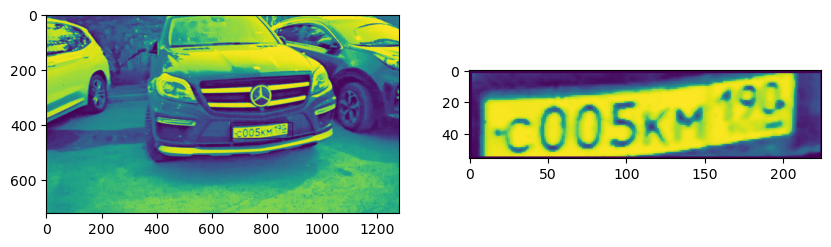

In [25]:
apply_pipeline('car2.jpg', 'с005км 190')

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


original	а715ае 977
detected	а7154е 977
CER: 0.1


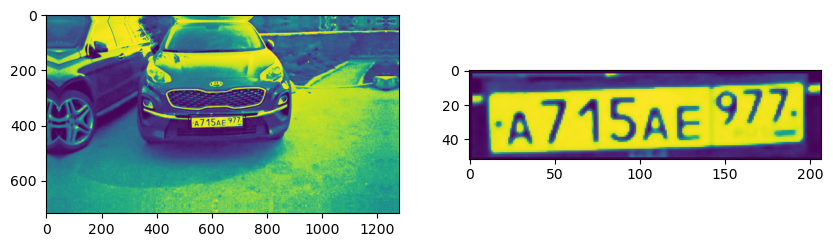

In [27]:
apply_pipeline('car3.jpg', 'а715ае 977')